# Homework 9 - Part 2 Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the short synopsis of the Lion King movie explained to kids in the text.text file.

Get familiar with the code and write a small report (2 or 3 pages, idk), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 8th, 11.59pm!**

Do not forget to write your name and student ID on the report.

### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()

### Testing for CUDA

We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [4]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

The dataset text consists of a short description of the story behing the movie The Lion King, explained in simple terms to kids.

In [5]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [6]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [7]:
text = create_text()
print(text)

['the', 'lion', 'king', 'is', 'an', 'animated', 'movie', 'made', 'by', 'walt', 'disney', 'in', '1994', 'it', 'was', 'the', 'most', 'successful', 'animated', 'movie', 'of', 'the', '1990s', 'the', 'movie', 'is', 'about', 'a', 'young', 'lion', 'prince', 'who', 'learns', 'about', 'his', 'role', 'as', 'prince', 'and', 'in', 'the', 'circle', 'of', 'life', 'it', 'is', 'dedicated', 'to', 'frank', 'wells', 'who', 'was', 'the', 'president', 'of', 'the', 'walt', 'disney', 'company', 'and', 'died', 'shortly', 'before', 'the', 'movie', 'was', 'released', 'into', 'theaters', 'on', 'june', '15', '1994', 'it', 'was', 'the', 'first', 'fulllength', 'disney', 'movie', 'to', 'feature', 'no', 'human', 'characters', 'since', 'bambi', 'much', 'of', 'the', 'voice', 'acting', 'work', 'was', 'done', 'by', 'wellknown', 'actors', 'including', 'james', 'earl', 'jones', 'jeremy', 'irons', 'matthew', 'broderick', 'whoopi', 'goldberg', 'rowan', 'atkinson', 'jonathan', 'taylor', 'thomas', 'and', 'nathan', 'lane', 'the

In [8]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - word2index, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [9]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [10]:
print("The dataset contains", len(vocab), "different words.")

The dataset contains 389 different words.


In [11]:
print("The dataset contains the following words:")
print(vocab)

The dataset contains the following words:
{'rowan', 'deep', 'bambi', 'going', 'cant', 'alone', 'mufasa', 'away', 'water', 'june', 'explains', 'across', 'waiting', 'happens', 'wonderful', 'leave', 'scars', 'one', 'because', 'interested', 'gorge', 'actors', 'know', 'much', 'sky', 'uks', 'rice', 'only', 'working', 'each', 'finds', 'whoopi', 'broderick', 'feature', 'president', 'land', 'music', 'than', '1990s', 'blames', 'fire', 'get', 'an', 'about', 'this', 'forbidden', 'won', 'dies', 'time', 'circle', 'killed', 'movies', 'when', 'life', 'role', 'jones', 'gump', 'become', 'relaxed', 'voice', 'is', 'london', 'comes', 'lane', 'they', 'field', 'songs', 'king', 'his', 'hits', 'up', 'walt', 'pocahontas', 'in', 'goldberg', 'wells', 'it', 'picks', 'scar', 'angry', 'on', 'shortly', 'appears', 'says', 'for', 'matata', 'were', 'jeremy', 'york', 'rescued', 'starts', 'ghost', 'collapses', 'worldwide', 'lyrics', 'hakuna', 'at', 'compared', 'song', 'live', 'who', 'a', 'two', 'learns', 'walks', 'lion', 

In [12]:
print(word2index)

{'rowan': 0, 'deep': 1, 'bambi': 2, 'going': 3, 'cant': 4, 'alone': 5, 'mufasa': 6, 'away': 7, 'water': 8, 'june': 9, 'explains': 10, 'across': 11, 'waiting': 12, 'happens': 13, 'wonderful': 14, 'leave': 15, 'scars': 16, 'one': 17, 'because': 18, 'interested': 19, 'gorge': 20, 'actors': 21, 'know': 22, 'much': 23, 'sky': 24, 'uks': 25, 'rice': 26, 'only': 27, 'working': 28, 'each': 29, 'finds': 30, 'whoopi': 31, 'broderick': 32, 'feature': 33, 'president': 34, 'land': 35, 'music': 36, 'than': 37, '1990s': 38, 'blames': 39, 'fire': 40, 'get': 41, 'an': 42, 'about': 43, 'this': 44, 'forbidden': 45, 'won': 46, 'dies': 47, 'time': 48, 'circle': 49, 'killed': 50, 'movies': 51, 'when': 52, 'life': 53, 'role': 54, 'jones': 55, 'gump': 56, 'become': 57, 'relaxed': 58, 'voice': 59, 'is': 60, 'london': 61, 'comes': 62, 'lane': 63, 'they': 64, 'field': 65, 'songs': 66, 'king': 67, 'his': 68, 'hits': 69, 'up': 70, 'walt': 71, 'pocahontas': 72, 'in': 73, 'goldberg': 74, 'wells': 75, 'it': 76, 'pick

In [13]:
print(index2word)

{0: 'rowan', 1: 'deep', 2: 'bambi', 3: 'going', 4: 'cant', 5: 'alone', 6: 'mufasa', 7: 'away', 8: 'water', 9: 'june', 10: 'explains', 11: 'across', 12: 'waiting', 13: 'happens', 14: 'wonderful', 15: 'leave', 16: 'scars', 17: 'one', 18: 'because', 19: 'interested', 20: 'gorge', 21: 'actors', 22: 'know', 23: 'much', 24: 'sky', 25: 'uks', 26: 'rice', 27: 'only', 28: 'working', 29: 'each', 30: 'finds', 31: 'whoopi', 32: 'broderick', 33: 'feature', 34: 'president', 35: 'land', 36: 'music', 37: 'than', 38: '1990s', 39: 'blames', 40: 'fire', 41: 'get', 42: 'an', 43: 'about', 44: 'this', 45: 'forbidden', 46: 'won', 47: 'dies', 48: 'time', 49: 'circle', 50: 'killed', 51: 'movies', 52: 'when', 53: 'life', 54: 'role', 55: 'jones', 56: 'gump', 57: 'become', 58: 'relaxed', 59: 'voice', 60: 'is', 61: 'london', 62: 'comes', 63: 'lane', 64: 'they', 65: 'field', 66: 'songs', 67: 'king', 68: 'his', 69: 'hits', 70: 'up', 71: 'walt', 72: 'pocahontas', 73: 'in', 74: 'goldberg', 75: 'wells', 76: 'it', 77: '

In [14]:
print(data)

[('king', ['the', 'lion', 'is', 'an']), ('is', ['lion', 'king', 'an', 'animated']), ('an', ['king', 'is', 'animated', 'movie']), ('animated', ['is', 'an', 'movie', 'made']), ('movie', ['an', 'animated', 'made', 'by']), ('made', ['animated', 'movie', 'by', 'walt']), ('by', ['movie', 'made', 'walt', 'disney']), ('walt', ['made', 'by', 'disney', 'in']), ('disney', ['by', 'walt', 'in', '1994']), ('in', ['walt', 'disney', '1994', 'it']), ('1994', ['disney', 'in', 'it', 'was']), ('it', ['in', '1994', 'was', 'the']), ('was', ['1994', 'it', 'the', 'most']), ('the', ['it', 'was', 'most', 'successful']), ('most', ['was', 'the', 'successful', 'animated']), ('successful', ['the', 'most', 'animated', 'movie']), ('animated', ['most', 'successful', 'movie', 'of']), ('movie', ['successful', 'animated', 'of', 'the']), ('of', ['animated', 'movie', 'the', '1990s']), ('the', ['movie', 'of', '1990s', 'the']), ('1990s', ['of', 'the', 'the', 'movie']), ('the', ['the', '1990s', 'movie', 'is']), ('movie', ['19

In [15]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.FloatTensor):
    """
    This function converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    
    tensor = dtype([word2index[word] for word in words])
    tensor = tensor.to(device)
    
    return Variable(tensor)

### Step 2. Create a SkipGram model and train

Task #1: Write your own model for the SkipGram model below.

In [16]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """

    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 512) # This additional linear layer helps to marginally improve the model!
        self.linear2 = nn.Linear(512, 2 * context_size * vocab_size)

    def forward(self, inputs):
        x = self.embeddings(inputs).view((1, -1))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        log_probs = F.log_softmax(x, dim=1).view(2 * self.context_size, -1)
        return log_probs

In [17]:
# Create model and pass to CUDA if available.
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.to(device)
model.train()

SkipGram(
  (embeddings): Embedding(389, 20)
  (linear1): Linear(in_features=20, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1556, bias=True)
)

In [18]:
# Define training parameters
learning_rate = 0.001
epochs = 825 # This is a custom number of epochs
torch.manual_seed(28)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [19]:
def get_prediction(context, model, word2index):
    """
    This is a helper function to get predictions from our model.
    """
    context_idxs = torch.tensor([word2index[context]], dtype=torch.long).cuda()
    log_probs = model(context_idxs)
    output_ids = torch.argmax(log_probs, dim=1)

    return output_ids

In [20]:
def check_accuracy(model, data, word2index):
    total_count = 0
    correct_count = 0

    for context, targets in data:
        output_ids = get_prediction(context, model, word2index).tolist()

        target_list = [word2index[w] for w in targets]

        for target in target_list:
            if target in output_ids:
                correct_count += 1
                output_ids.remove(target)

        total_count += len(target_list)

    return correct_count / total_count

In [21]:
def train(data, word2index, model, epochs, loss_func, optimizer):
    """
    This is a trainer function to train our SkipGram model.
    """
    losses = []
    accuracies = []
    for epoch_no in range(epochs):
        model.train()

        e_loss = 0
        for context, targets in data:
            # Step 1. Prepare the inputs to be passed to the model (i.e, turn 
            # the words into integer indices and wrap them in tensors)
            context_idxs = torch.tensor([word2index[context]], dtype=torch.long).cuda()

            # Step 2. Recall that torch *accumulates* gradients. Before passing 
            # in a new instance, you need to zero out the gradients from the old
            # instance
            optimizer.zero_grad()

            # Step 3. Run the forward pass, getting log probabilities over next
            # words
            log_probs = model(context_idxs)

            # Step 4. Compute your loss function. (Again, Torch wants the target
            # word wrapped in a tensor)
            target_list = torch.tensor([word2index[w] for w in targets], dtype=torch.long).cuda()
            loss = loss_func(log_probs, target_list)

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Step 6. Get the Python number from a 1-element Tensor by calling tensor.item()
            e_loss += loss.item()

        model.eval()

        with torch.no_grad():
            e_loss /= len(data)
            accuracy = check_accuracy(model, data, word2index)

            print(f"Epoch {epoch_no+1}: loss - {e_loss}; accuracy - {accuracy}")

            losses.append(e_loss)
            accuracies.append(accuracy)

    return losses, accuracies, model

losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer)

Epoch 1: loss - 7.3277794208951255; accuracy - 0.0939239332096475
Epoch 2: loss - 7.20163759052864; accuracy - 0.09485157699443414
Epoch 3: loss - 7.084025919990327; accuracy - 0.08441558441558442
Epoch 4: loss - 6.978375266788178; accuracy - 0.08024118738404452
Epoch 5: loss - 6.887717306282171; accuracy - 0.08024118738404452
Epoch 6: loss - 6.812297085884109; accuracy - 0.08024118738404452
Epoch 7: loss - 6.749457310214777; accuracy - 0.0839517625231911
Epoch 8: loss - 6.695868478856414; accuracy - 0.08905380333951762
Epoch 9: loss - 6.649014066013201; accuracy - 0.10041743970315399
Epoch 10: loss - 6.6071904868938045; accuracy - 0.11062152133580705
Epoch 11: loss - 6.56918681486197; accuracy - 0.11665120593692022
Epoch 12: loss - 6.5341241585301555; accuracy - 0.12036178107606679
Epoch 13: loss - 6.501382026247722; accuracy - 0.12708719851576994
Epoch 14: loss - 6.470530901415229; accuracy - 0.13218923933209648
Epoch 15: loss - 6.441264029557718; accuracy - 0.13868274582560297
Epoch

### 3. Visualization

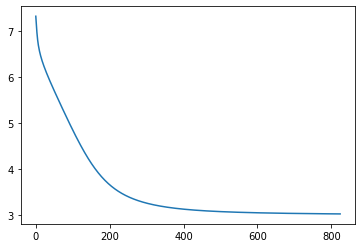

In [22]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

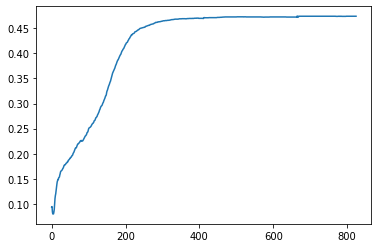

In [23]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

### 4. Extract embedding and play with it? (Optional)

In [24]:
# Save the trained model
torch.save(model.state_dict(), "model.pth")

In [25]:
# Load the trained model
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.load_state_dict(torch.load("model.pth"))
model.eval()

SkipGram(
  (embeddings): Embedding(389, 20)
  (linear1): Linear(in_features=20, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1556, bias=True)
)

In [26]:
# Inspect the model's state_dict
model.state_dict()

OrderedDict([('embeddings.weight',
              tensor([[-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
                      [ 0.7299, -1.3819,  0.1418,  ...,  1.6372, -0.9238,  0.7384],
                      [ 2.4948,  1.0473, -0.4565,  ..., -0.0041,  0.3968,  1.8590],
                      ...,
                      [-0.4269, -0.3590,  0.2175,  ..., -1.4402,  0.1553, -0.2601],
                      [-0.3633, -0.1142, -1.8354,  ..., -1.0230, -1.2687, -1.1595],
                      [-1.6997, -0.2512,  0.5528,  ..., -1.0109,  1.5953,  0.5354]],
                     device='cuda:0')),
             ('linear1.weight',
              tensor([[ 0.0665,  0.1744,  0.0909,  ..., -0.0578, -0.1217, -0.1218],
                      [ 0.0216, -0.6805,  0.2752,  ...,  0.3176, -0.3904, -0.6062],
                      [-0.2093, -0.2896, -0.0120,  ..., -0.2630,  0.2270, -0.3779],
                      ...,
                      [ 0.4554, -0.6091,  0.0318,  ..., -0.3545,  0.0031,  0.3905]

In [27]:
# Inspect the model's embedding weights
model.state_dict()['embeddings.weight']

tensor([[-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [ 0.7299, -1.3819,  0.1418,  ...,  1.6372, -0.9238,  0.7384],
        [ 2.4948,  1.0473, -0.4565,  ..., -0.0041,  0.3968,  1.8590],
        ...,
        [-0.4269, -0.3590,  0.2175,  ..., -1.4402,  0.1553, -0.2601],
        [-0.3633, -0.1142, -1.8354,  ..., -1.0230, -1.2687, -1.1595],
        [-1.6997, -0.2512,  0.5528,  ..., -1.0109,  1.5953,  0.5354]],
       device='cuda:0')

In [28]:
# Extract the embedding weights
embedding_layer = nn.Embedding(len(vocab), 20)
embedding_layer.weight = torch.nn.Parameter(model.state_dict()['embeddings.weight'])
embedding_layer.eval()

Embedding(389, 20)

In [46]:
print([word2index['his']])

[68]


In [47]:
his_context_id = torch.zeros(len(vocab)).cuda().long()
his_context_id[word2index['his']] = 1.
his_vec = embedding_layer(his_context_id)
print(his_vec)

tensor([[-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        ...,
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)


In [48]:
her_context_id = torch.zeros(len(vocab)).cuda().long()
her_context_id[word2index['her']] = 1.
her_vec = embedding_layer(her_context_id)
print(her_vec)

tensor([[-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        ...,
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)


In [49]:
lion_context_id = torch.zeros(len(vocab)).cuda().long()
lion_context_id[word2index['lion']] = 1.
lion_vec = embedding_layer(lion_context_id)
print(lion_vec)

tensor([[-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        ...,
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)


In [50]:
lioness_context_id = torch.zeros(len(vocab)).cuda().long()
lioness_context_id[word2index['lioness']] = 1.
lioness_vec = embedding_layer(lioness_context_id)
print(lioness_vec)

tensor([[-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        ...,
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749],
        [-0.8982, -0.3106, -1.1535,  ..., -0.7977, -0.3934,  1.7749]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)


In [54]:
his_her_sim = F.cosine_similarity(his_vec, her_vec, dim=0)
print(f"Cosine similarity of 'his' and 'her': {his_her_sim}")
lion_lioness_sim = F.cosine_similarity(lion_vec, lioness_vec, dim=0)
print(f"Cosine similarity of 'lion' and 'lioness': {lion_lioness_sim}")

Cosine similarity of 'his' and 'her': tensor([0.9915, 0.9708, 0.9967, 1.0000, 0.5326, 0.9839, 1.0000, 0.8660, 1.0000,
        0.9633, 0.9975, 0.9795, 0.9995, 0.9999, 0.7005, 0.9991, 0.9985, 0.9762,
        0.9954, 0.9991], device='cuda:0', grad_fn=<DivBackward0>)
Cosine similarity of 'lion' and 'lioness': tensor([0.9915, 0.9708, 0.9967, 1.0000, 0.5326, 0.9839, 1.0000, 0.8660, 1.0000,
        0.9633, 0.9975, 0.9795, 0.9995, 0.9999, 0.7005, 0.9991, 0.9985, 0.9762,
        0.9954, 0.9991], device='cuda:0', grad_fn=<DivBackward0>)


In [55]:
his_lion_sim = F.cosine_similarity(his_vec, lion_vec, dim=0)
print(f"Cosine similarity of 'his' and 'lion': {his_lion_sim}")
his_lioness_sim = F.cosine_similarity(his_vec, lioness_vec, dim=0)
print(f"Cosine similarity of 'his' and 'lioness': {his_lioness_sim}")
her_lion_sim = F.cosine_similarity(her_vec, lion_vec, dim=0)
print(f"Cosine similarity of 'her' and 'lion': {her_lion_sim}")
her_lioness_sim = F.cosine_similarity(her_vec, lioness_vec, dim=0)
print(f"Cosine similarity of 'her' and 'lioness': {her_lioness_sim}")

Cosine similarity of 'his' and 'lion': tensor([0.9915, 0.9708, 0.9967, 1.0000, 0.5326, 0.9839, 1.0000, 0.8660, 1.0000,
        0.9633, 0.9975, 0.9795, 0.9995, 0.9999, 0.7005, 0.9991, 0.9985, 0.9762,
        0.9954, 0.9991], device='cuda:0', grad_fn=<DivBackward0>)
Cosine similarity of 'his' and 'lioness': tensor([0.9915, 0.9708, 0.9967, 1.0000, 0.5326, 0.9839, 1.0000, 0.8660, 1.0000,
        0.9633, 0.9975, 0.9795, 0.9995, 0.9999, 0.7005, 0.9991, 0.9985, 0.9762,
        0.9954, 0.9991], device='cuda:0', grad_fn=<DivBackward0>)
Cosine similarity of 'her' and 'lion': tensor([0.9915, 0.9708, 0.9967, 1.0000, 0.5326, 0.9839, 1.0000, 0.8660, 1.0000,
        0.9633, 0.9975, 0.9795, 0.9995, 0.9999, 0.7005, 0.9991, 0.9985, 0.9762,
        0.9954, 0.9991], device='cuda:0', grad_fn=<DivBackward0>)
Cosine similarity of 'her' and 'lioness': tensor([0.9915, 0.9708, 0.9967, 1.0000, 0.5326, 0.9839, 1.0000, 0.8660, 1.0000,
        0.9633, 0.9975, 0.9795, 0.9995, 0.9999, 0.7005, 0.9991, 0.9985, 0.9762,


In [56]:
def predict_context_words(skipgram_model, sample_input):
    context_pred_idxs = get_prediction(sample_input, skipgram_model, word2index).tolist()
    context_preds = [index2word[idx] for idx in context_pred_idxs]
    return context_preds

# Initialize another untrained SkipGram model to compare against
untrained_model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
untrained_model = untrained_model.cuda()

# Get predictions
untrained_predictions = predict_context_words(untrained_model, "lion")
trained_predictions = predict_context_words(model, "lion")

print("Predicted Context Words from Untrained Model: {}".format(untrained_predictions))
print("Predicted Context Words from Trained Model: {}".format(trained_predictions))

Predicted Context Words from Untrained Model: ['being', 'company', 'as', 'wells']
Predicted Context Words from Trained Model: ['lioness', 'the', 'king', 'to']


### Questions and expected answers for the report

The questions listed below are related to Part 2.

P2-QA. Copy and paste your SkipGram class code (Task #1 in this notebook).

P2-QB. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g., a function to compute the accuracy of your model after each iteration).
Please also copy and paste the function call with the parameters you used for the train() function.

P2-QC. Why is the SkipGram model much more difficult to train than the CBoW?
Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

P2-QD. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so?

P2-QE. (Optional) Please submit any additional code you might that will demonstrate the performance/problems of the word embedding you have trained!